In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from transformers import DeiTModel, DeiTFeatureExtractor, Trainer, TrainingArguments, AutoModel, AutoTokenizer
from torchvision import transforms
import matplotlib.pyplot as plt
from fracture_dataset import FractureDataset
from utils import compute_metrics, compute_additional_metrics, plot_confusion_matrix, compute_all_metrics_with_ci

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_dir = "AI FRACTURES"

feature_extractor = DeiTFeatureExtractor.from_pretrained("facebook/deit-tiny-patch16-224")

image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

with open("fracture_data_split.pkl", "rb") as f:
    split_data = pickle.load(f)

train_dataset = FractureDataset(split_data["train"], split_data["train_labels"], root_dir, image_transform, tokenizer=tokenizer)
test_dataset = FractureDataset(split_data["test"], split_data["test_labels"], root_dir, image_transform, tokenizer=tokenizer)
val_dataset = FractureDataset(split_data["val"], split_data["val_labels"], root_dir, image_transform, tokenizer=tokenizer)

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\transformers\models\deit\feature_extraction_deit.py:30: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(


In [3]:
class Model_Fusion1(nn.Module):
    def __init__(self, text_model_name="huawei-noah/TinyBERT_General_4L_312D",
                 image_model_name="facebook/deit-tiny-patch16-224",
                 num_labels=1):
        super(Model_Fusion1, self).__init__()

        # Text Encoder
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        text_hidden_size = self.text_encoder.config.hidden_size

        # Freeze text encoder layers
        for param in self.text_encoder.parameters():
            param.requires_grad = False

        # Image Encoder
        self.image_encoder = DeiTModel.from_pretrained(image_model_name)
        image_hidden_size = self.image_encoder.config.hidden_size

        # Freeze image encoder layers
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(text_hidden_size + image_hidden_size, num_labels)

        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, pixel_values, labels=None):
        # Text embeddings
        text_embeddings = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_embeddings = text_embeddings.last_hidden_state[:, 0]

        # Image embeddings
        image_embeddings = self.image_encoder(pixel_values=pixel_values)
        image_embeddings = image_embeddings.last_hidden_state[:, 0]

        # Concatenate
        fused_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)

        # Pass through classifier
        logits = self.classifier(self.dropout(fused_embeddings))

        loss = None
        if labels is not None:
            loss = F.binary_cross_entropy_with_logits(logits, labels)

        return {
            "loss": loss,
            "logits": logits
        }

In [4]:
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    pixel_values = torch.stack([item['pixel_values'][0] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "pixel_values": pixel_values,
        "labels": labels
    }

In [6]:
model = Model_Fusion1(num_labels=1)

# Training setup
training_args = TrainingArguments(
    output_dir='./fusion1_fracture_output',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    learning_rate=1e-2,
    warmup_steps=200,
    lr_scheduler_type='cosine',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_strategy="epoch",
    weight_decay=1e-4,
    logging_dir="./logs",
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    data_collator = collate_fn,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized: ['embeddings.cls_token', 'embeddings.distillation_token', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings', 'encoder.layer.0.attention.attention.key.bias', 'encoder.layer.0.attention.attention.key.weight', 'encoder.layer.0.attention.attention.query.bias', 'encoder.layer.0.attention.attention.query.weight', 'encoder.layer.0.attention.attention.value.bias', 'encoder.layer.0.attention.attention.value.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.layernorm_after.bias', 'enc

In [7]:
trainer.train()
print('Training complete.')

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Roc Auc
1,0.699100,0.670793,0.500000,0.000000,0.500000
2,0.690200,0.677318,0.500000,0.000000,0.500000
3,0.685800,0.687555,0.500000,0.000000,0.500000
4,0.688800,0.694063,0.500000,0.000000,0.500000
5,0.686800,0.705358,0.500000,0.000000,0.500000
6,0.664200,0.676125,0.500000,0.000000,0.500000
7,0.664200,0.683534,0.500000,0.000000,0.500000
8,0.629100,0.647216,0.700000,0.571429,0.700000
9,0.667300,0.663042,0.600000,0.500000,0.600000
10,0.634000,0.643549,0.500000,0.000000,0.500000


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: '

Training complete.


In [8]:
torch.save(model.state_dict(), "fusion1_fracture_model.pth")

In [9]:
# Save the model
trainer.save_model()

# Evaluate
trainer.evaluate()

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.647215723991394,
 'eval_accuracy': 0.7,
 'eval_f1': 0.5714285714285714,
 'eval_roc_auc': 0.7,
 'eval_runtime': 2.5159,
 'eval_samples_per_second': 3.975,
 'eval_steps_per_second': 0.795,
 'epoch': 10.0}

In [10]:
model.load_state_dict(torch.load("fusion1_fracture_model.pth"))
trainer.evaluate(test_dataset)

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.6780396699905396,
 'eval_accuracy': 0.5,
 'eval_f1': 0.0,
 'eval_roc_auc': 0.5,
 'eval_runtime': 2.0838,
 'eval_samples_per_second': 4.799,
 'eval_steps_per_second': 0.96,
 'epoch': 10.0}

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


f1: 0.6667
roc_auc: 0.6000
matthews_corrcoef: 0.2182
brier_score: 0.4000
sensitivity: 0.8000
specificity: 0.4000
balanced_accuracy: 0.6000


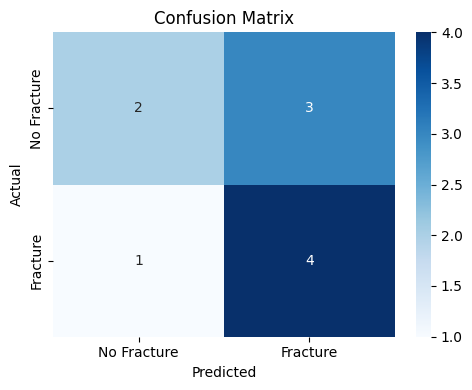

In [11]:
# Run evaluation
predictions = trainer.predict(test_dataset)

# Extract logits and compute probabilities using sigmoid if binary
logits = predictions.predictions
y_pred_probs = 1 / (1 + np.exp(-logits))  # Sigmoid for binary
y_pred_probs = y_pred_probs.squeeze()    # Remove extra dimension if needed
y_pred = (y_pred_probs >= 0.5).astype(int)  # Get predicted class labels

# Ground truth labels
y_true = predictions.label_ids.squeeze()

# Compute and print metrics
metrics = compute_additional_metrics(y_true, y_pred)
for key, value in metrics.items():
    if key != "confusion_matrix":
        print(f"{key}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(metrics["confusion_matrix"])

In [12]:
results = compute_all_metrics_with_ci(y_true, y_pred, y_prob=y_pred_probs, multilabel=False)

for metric, (mean_val, (low, high)) in results.items():
    if mean_val is not None:
        print(f"{metric}: {mean_val:.3f} (90% CI: {low:.3f} - {high:.3f})")
    else:
        print(f"{metric}: Not available")

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Error computing sensitivity for bootstrap sample
not enough values to unpack (expected 4, got 1)


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


accuracy: 0.603 (90% CI: 0.300 - 0.800)
f1: 0.646 (90% CI: 0.333 - 0.889)
auroc: 0.677 (90% CI: 0.333 - 1.000)
mcc: 0.202 (90% CI: -0.356 - 0.667)
brier: 0.402 (90% CI: 0.200 - 0.700)
sensitivity: 0.809 (90% CI: 0.500 - 1.000)
specificity: 0.393 (90% CI: 0.000 - 0.800)
balanced_accuracy: 0.597 (90% CI: 0.333 - 0.833)


In [13]:
model = Model_Fusion1(num_labels=1)
# Set the model to evaluation model
model.eval()
model.load_state_dict(torch.load("fusion1_fracture_model.pth"))

You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized: ['embeddings.cls_token', 'embeddings.distillation_token', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings', 'encoder.layer.0.attention.attention.key.bias', 'encoder.layer.0.attention.attention.key.weight', 'encoder.layer.0.attention.attention.query.bias', 'encoder.layer.0.attention.attention.query.weight', 'encoder.layer.0.attention.attention.value.bias', 'encoder.layer.0.attention.attention.value.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.layernorm_after.bias', 'enc

<All keys matched successfully>

In [14]:
# from torchview import draw_graph

# sample_input = next(iter(train_dataset))
# dummy_inputs = {
#     "input_ids": sample_input["input_ids"].unsqueeze(0),  # Add batch dimension
#     "attention_mask": sample_input["attention_mask"].unsqueeze(0),  # Add batch dimension
#     "pixel_values": sample_input["pixel_values"][0].unsqueeze(0)  # Add batch dimension
# }

# # Pass the inputs to your model (unpack the dictionary)
# output = model(
#     input_ids=dummy_inputs["input_ids"],
#     attention_mask=dummy_inputs["attention_mask"],
#     pixel_values=dummy_inputs["pixel_values"]
# )

# model_graph = draw_graph(
#     model,
#     input_data={
#         "input_ids": dummy_inputs["input_ids"],
#         "attention_mask": dummy_inputs["attention_mask"],
#         "pixel_values": dummy_inputs["pixel_values"]
#     },
#     graph_name='Fusion1 Fracture Model Graph',
#     save_graph=True,
#     expand_nested=False
# )

In [15]:
class Model_Fusion2(nn.Module):
    def __init__(self, text_model_name="huawei-noah/TinyBERT_General_4L_312D",
                 image_model_name="facebook/deit-tiny-patch16-224",
                 num_labels=1):
        super(Model_Fusion2, self).__init__()

        # Text Encoder
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        text_hidden_size = self.text_encoder.config.hidden_size

        # Freeze text encoder layers
        for param in self.text_encoder.parameters():
            param.requires_grad = False

        # Image Encoder
        self.image_encoder = DeiTModel.from_pretrained(image_model_name)
        image_hidden_size = self.image_encoder.config.hidden_size

        # Freeze image encoder layers
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        self.text_proj = nn.Linear(text_hidden_size, 256)
        self.image_proj = nn.Linear(image_hidden_size, 256)
        self.gate = nn.Sequential(
            nn.Linear(512, 1), 
            nn.Sigmoid()
            )

        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(256, num_labels)

        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, pixel_values, labels=None):
        # Text embeddings
        text_embeddings = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_embeddings = text_embeddings.last_hidden_state[:, 0]
        text_embeddings = self.text_proj(text_embeddings)

        # Image embeddings
        image_embeddings = self.image_encoder(pixel_values=pixel_values)
        image_embeddings = image_embeddings.last_hidden_state[:, 0]
        image_embeddings = self.image_proj(image_embeddings)

        # Concatenate
        fused_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)

        # Apply gate
        gate_values = self.gate(fused_embeddings)
        fused_embeddings = gate_values * text_embeddings + (1 - gate_values) * image_embeddings

        # Pass through classifier
        logits = self.classifier(self.dropout(fused_embeddings))

        loss = None
        if labels is not None:
            loss = F.binary_cross_entropy_with_logits(logits, labels)

        return {
            "loss": loss,
            "logits": logits
        }

In [16]:
model = Model_Fusion2(num_labels=1)

# Training setup
training_args = TrainingArguments(
    output_dir='./fusion2_fracture_output',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    learning_rate=1e-2,
    warmup_steps=200,
    lr_scheduler_type='cosine',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_strategy="epoch",
    weight_decay=1e-4,
    logging_dir="./logs",
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    data_collator = collate_fn,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized: ['embeddings.cls_token', 'embeddings.distillation_token', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings', 'encoder.layer.0.attention.attention.key.bias', 'encoder.layer.0.attention.attention.key.weight', 'encoder.layer.0.attention.attention.query.bias', 'encoder.layer.0.attention.attention.query.weight', 'encoder.layer.0.attention.attention.value.bias', 'encoder.layer.0.attention.attention.value.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.layernorm_after.bias', 'enc

In [17]:
trainer.train()
print('Training complete.')

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Roc Auc
1,0.697900,0.683300,0.500000,0.000000,0.500000
2,0.694700,0.676316,0.500000,0.000000,0.500000
3,0.674500,0.651275,0.500000,0.000000,0.500000
4,0.673700,0.616428,0.500000,0.000000,0.500000
5,0.648600,0.582242,0.700000,0.571429,0.700000
6,0.598600,0.563196,0.800000,0.750000,0.800000
7,0.587600,0.493505,0.900000,0.888889,0.900000
8,0.665500,0.524088,0.600000,0.333333,0.600000
9,0.739700,0.665214,0.500000,0.000000,0.500000
10,0.893100,1.486529,0.500000,0.666667,0.500000


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: '

Training complete.


In [18]:
torch.save(model.state_dict(), "fusion2_fracture_model.pth")

In [19]:
# Save the model
trainer.save_model()

# Evaluate
trainer.evaluate()

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.49350517988204956,
 'eval_accuracy': 0.9,
 'eval_f1': 0.8888888888888888,
 'eval_roc_auc': 0.9,
 'eval_runtime': 6.1658,
 'eval_samples_per_second': 1.622,
 'eval_steps_per_second': 0.324,
 'epoch': 10.0}

In [20]:
model.load_state_dict(torch.load("fusion2_fracture_model.pth"))
trainer.evaluate(test_dataset)

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.4400561451911926,
 'eval_accuracy': 0.8,
 'eval_f1': 0.8,
 'eval_roc_auc': 0.8,
 'eval_runtime': 5.0294,
 'eval_samples_per_second': 1.988,
 'eval_steps_per_second': 0.398,
 'epoch': 10.0}

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


f1: 0.9091
roc_auc: 0.9000
matthews_corrcoef: 0.8165
brier_score: 0.1000
sensitivity: 1.0000
specificity: 0.8000
balanced_accuracy: 0.9000


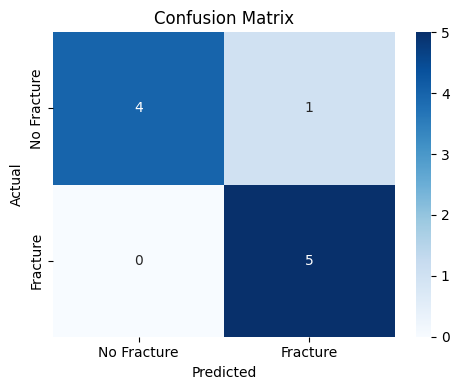

In [21]:
# Run evaluation
predictions = trainer.predict(test_dataset)

# Extract logits and compute probabilities using sigmoid if binary
logits = predictions.predictions
y_pred_probs = 1 / (1 + np.exp(-logits))  # Sigmoid for binary
y_pred_probs = y_pred_probs.squeeze()    # Remove extra dimension if needed
y_pred = (y_pred_probs >= 0.5).astype(int)  # Get predicted class labels

# Ground truth labels
y_true = predictions.label_ids.squeeze()

# Compute and print metrics
metrics = compute_additional_metrics(y_true, y_pred)
for key, value in metrics.items():
    if key != "confusion_matrix":
        print(f"{key}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(metrics["confusion_matrix"])

In [22]:
results = compute_all_metrics_with_ci(y_true, y_pred, y_prob=y_pred_probs, multilabel=False)

for metric, (mean_val, (low, high)) in results.items():
    if mean_val is not None:
        print(f"{metric}: {mean_val:.3f} (90% CI: {low:.3f} - {high:.3f})")
    else:
        print(f"{metric}: Not available")

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Error computing sensitivity for bootstrap sample
not enough values to unpack (expected 4, got 1)


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Error computing specificity for bootstrap sample
not enough values to unpack (expected 4, got 1)


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


accuracy: 0.902 (90% CI: 0.700 - 1.000)
f1: 0.899 (90% CI: 0.667 - 1.000)
auroc: 0.961 (90% CI: 0.833 - 1.000)
mcc: 0.818 (90% CI: 0.535 - 1.000)
brier: 0.099 (90% CI: 0.000 - 0.300)
sensitivity: 1.000 (90% CI: 1.000 - 1.000)
specificity: 0.794 (90% CI: 0.500 - 1.000)
balanced_accuracy: 0.900 (90% CI: 0.750 - 1.000)


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [23]:
model = Model_Fusion2(num_labels=1)
# Set the model to evaluation model
model.eval()
model.load_state_dict(torch.load("fusion2_fracture_model.pth"))

You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized: ['embeddings.cls_token', 'embeddings.distillation_token', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings', 'encoder.layer.0.attention.attention.key.bias', 'encoder.layer.0.attention.attention.key.weight', 'encoder.layer.0.attention.attention.query.bias', 'encoder.layer.0.attention.attention.query.weight', 'encoder.layer.0.attention.attention.value.bias', 'encoder.layer.0.attention.attention.value.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.layernorm_after.bias', 'enc

<All keys matched successfully>

In [24]:
# from torchview import draw_graph

# sample_input = next(iter(train_dataset))
# dummy_inputs = {
#     "input_ids": sample_input["input_ids"].unsqueeze(0),  # Add batch dimension
#     "attention_mask": sample_input["attention_mask"].unsqueeze(0),  # Add batch dimension
#     "pixel_values": sample_input["pixel_values"][0].unsqueeze(0)  # Add batch dimension
# }

# # Pass the inputs to your model (unpack the dictionary)
# output = model(
#     input_ids=dummy_inputs["input_ids"],
#     attention_mask=dummy_inputs["attention_mask"],
#     pixel_values=dummy_inputs["pixel_values"]
# )

# model_graph = draw_graph(
#     model,
#     input_data={
#         "input_ids": dummy_inputs["input_ids"],
#         "attention_mask": dummy_inputs["attention_mask"],
#         "pixel_values": dummy_inputs["pixel_values"]
#     },
#     graph_name='Fusion2 Fracture Model Graph',
#     save_graph=True,
#     expand_nested=False
# )

In [5]:
class Model_Fusion3(nn.Module):
    def __init__(self, text_model_name="huawei-noah/TinyBERT_General_4L_312D",
                 image_model_name="facebook/deit-tiny-patch16-224",
                 num_labels=1):
        super(Model_Fusion3, self).__init__()

        # Text Encoder
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        text_hidden_size = self.text_encoder.config.hidden_size

        # Freeze text encoder layers
        for param in self.text_encoder.parameters():
            param.requires_grad = False

        # Image Encoder
        self.image_encoder = DeiTModel.from_pretrained(image_model_name)
        image_hidden_size = self.image_encoder.config.hidden_size

        # Freeze image encoder layers
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        self.text_proj = nn.Linear(text_hidden_size, image_hidden_size)

        self.cross_attention = nn.MultiheadAttention(embed_dim=image_hidden_size, num_heads=4, batch_first=True)

        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(text_hidden_size + image_hidden_size, num_labels)

        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, pixel_values, labels=None):
        # Text embeddings
        text_embeddings = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_tokens = text_embeddings.last_hidden_state
        text_tokens = self.text_proj(text_tokens)

        # Image embeddings
        image_embeddings = self.image_encoder(pixel_values=pixel_values)
        image_tokens = image_embeddings.last_hidden_state

        # Cross-attention
        cross_attended, _ = self.cross_attention(query=image_tokens, key=text_tokens, value=text_tokens)
        image_enhanced = cross_attended[:, 0]  # Use the first token for classification

        # Concatenate
        text_cls = text_embeddings.last_hidden_state[:, 0]
        fused_embeddings = torch.cat((text_cls, image_enhanced), dim=1)

        # Pass through classifier
        logits = self.classifier(self.dropout(fused_embeddings))

        loss = None
        if labels is not None:
            loss = F.binary_cross_entropy_with_logits(logits, labels)

        return {
            "loss": loss,
            "logits": logits
        }

In [6]:
model = Model_Fusion3(num_labels=1)

# Training setup
training_args = TrainingArguments(
    output_dir='./fusion3_fracture_output',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    learning_rate=1e-2,
    warmup_steps= 200,
    lr_scheduler_type='cosine',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_strategy="epoch",
    weight_decay=1e-4,
    logging_dir="./logs",
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    data_collator = collate_fn,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized: ['embeddings.cls_token', 'embeddings.distillation_token', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings', 'encoder.layer.0.attention.attention.key.bias', 'encoder.layer.0.attention.attention.key.weight', 'encoder.layer.0.attention.attention.query.bias', 'encoder.layer.0.attention.attention.query.weight', 'encoder.layer.0.attention.attention.value.bias', 'encoder.layer.0.attention.attention.value.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.layernorm_after.bias', 'enc

In [27]:
trainer.train()
print('Training complete.')

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Roc Auc
1,0.693100,0.687763,0.500000,0.000000,0.500000
2,0.684000,0.609230,0.500000,0.000000,0.500000
3,0.572900,0.216936,1.000000,1.000000,1.000000
4,0.429000,0.116032,0.900000,0.888889,0.900000
5,0.876500,0.167643,0.900000,0.888889,0.900000
6,0.340500,0.011587,1.000000,1.000000,1.000000
7,0.241700,0.011099,1.000000,1.000000,1.000000
8,0.108700,0.009203,1.000000,1.000000,1.000000
9,0.085300,0.005962,1.000000,1.000000,1.000000
10,0.297100,0.000014,1.000000,1.000000,1.000000


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: '

Training complete.


In [28]:
torch.save(model.state_dict(), "fusion3_fracture_model.pth")

In [29]:
# Save the model
trainer.save_model()

# Evaluate

trainer.evaluate()

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.2169356793165207,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_roc_auc': 1.0,
 'eval_runtime': 5.7574,
 'eval_samples_per_second': 1.737,
 'eval_steps_per_second': 0.347,
 'epoch': 10.0}

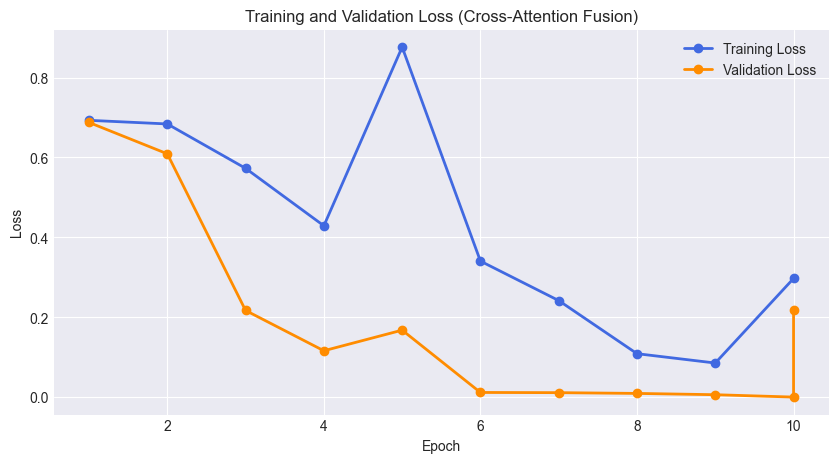

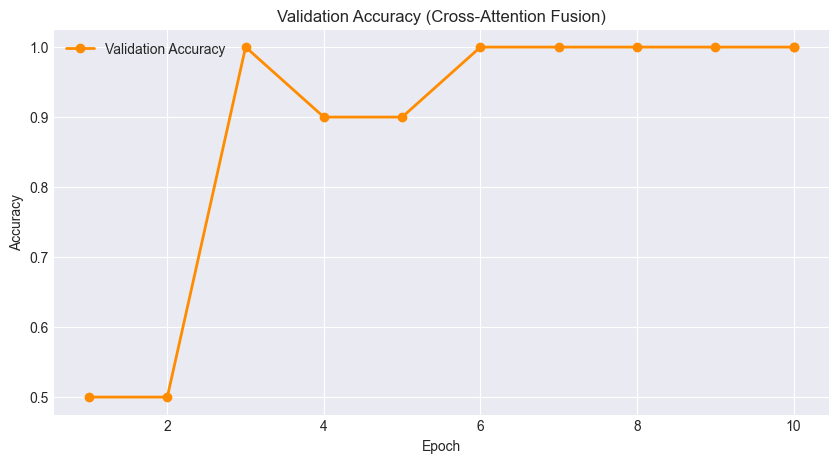

In [30]:
# Extract logs
logs = trainer.state.log_history

train_loss = []
eval_loss = []
eval_accuracy = []
train_epochs = []
eval_epochs = []

for log in logs:
    if "loss" in log and "epoch" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])  # store matching epoch
    if "eval_accuracy" in log:
        eval_accuracy.append(log["eval_accuracy"])

plt.style.use('seaborn-v0_8-darkgrid')
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_loss, label="Training Loss", marker='o', linewidth=2, color='royalblue')
plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker='o', linewidth=2, color='darkorange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (Cross-Attention Fusion)")
plt.legend()
plt.grid(True)
plt.savefig("fusion3_fracture_loss.png")
plt.show()

# Plot Accuracy (optional, if accuracy was computed)
if eval_accuracy:
    plt.figure(figsize=(10, 5))
    plt.plot(eval_epochs[:len(eval_accuracy)], eval_accuracy, label="Validation Accuracy", marker='o', linewidth=2, color='darkorange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy (Cross-Attention Fusion)")
    plt.legend()
    plt.grid(True)
    plt.savefig("fusion3_fracture_accuracy.png")
    plt.show()

In [8]:
model.load_state_dict(torch.load("fusion3_fracture_model.pth"))
trainer.evaluate(test_dataset)

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.16320590674877167,
 'eval_model_preparation_time': 0.004,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_roc_auc': 1.0,
 'eval_runtime': 1.9658,
 'eval_samples_per_second': 5.087,
 'eval_steps_per_second': 1.017}

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


f1: 1.0000
roc_auc: 1.0000
matthews_corrcoef: 1.0000
brier_score: 0.0000
sensitivity: 1.0000
specificity: 1.0000
balanced_accuracy: 1.0000


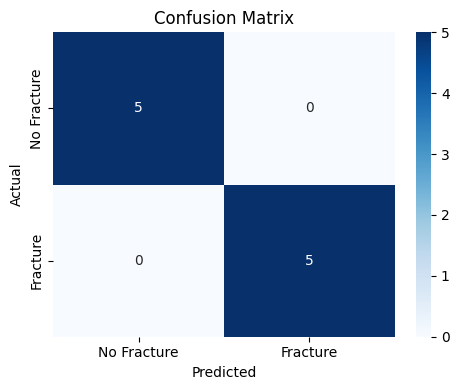

In [9]:
# Run evaluation
predictions = trainer.predict(test_dataset)

# Extract logits and compute probabilities using sigmoid if binary
logits = predictions.predictions
y_pred_probs = 1 / (1 + np.exp(-logits))  # Sigmoid for binary
y_pred_probs = y_pred_probs.squeeze()    # Remove extra dimension if needed
y_pred = (y_pred_probs >= 0.5).astype(int)  # Get predicted class labels

# Ground truth labels
y_true = predictions.label_ids.squeeze()

# Compute and print metrics
metrics = compute_additional_metrics(y_true, y_pred)
for key, value in metrics.items():
    if key != "confusion_matrix":
        print(f"{key}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(metrics["confusion_matrix"])

In [12]:
print("Confidence scores for test set:")
for i, score in enumerate(y_pred_probs):
    if y_pred[i] == 1:
        print(f"Sample {i+1}: {score:.4f} confidence for fracture")
    else:
        print(f"Sample {i+1}: {1-score:.4f} confidence for no fracture")

Confidence scores for test set:
Sample 1: 0.8544 confidence for fracture
Sample 2: 0.7361 confidence for no fracture
Sample 3: 0.7096 confidence for no fracture
Sample 4: 0.9699 confidence for fracture
Sample 5: 0.8885 confidence for fracture
Sample 6: 0.9895 confidence for fracture
Sample 7: 0.7084 confidence for no fracture
Sample 8: 0.9559 confidence for fracture
Sample 9: 0.7893 confidence for no fracture
Sample 10: 0.9614 confidence for no fracture


In [33]:
results = compute_all_metrics_with_ci(y_true, y_pred, y_prob=y_pred_probs, multilabel=False)

for metric, (mean_val, (low, high)) in results.items():
    if mean_val is not None:
        print(f"{metric}: {mean_val:.3f} (90% CI: {low:.3f} - {high:.3f})")
    else:
        print(f"{metric}: Not available")

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnin

Error computing sensitivity for bootstrap sample
not enough values to unpack (expected 4, got 1)


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Error computing specificity for bootstrap sample
not enough values to unpack (expected 4, got 1)


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\ENVY\OneDr

accuracy: 1.000 (90% CI: 1.000 - 1.000)
f1: 0.998 (90% CI: 1.000 - 1.000)
auroc: 1.000 (90% CI: 1.000 - 1.000)
mcc: 0.998 (90% CI: 1.000 - 1.000)
brier: 0.000 (90% CI: 0.000 - 0.000)
sensitivity: 1.000 (90% CI: 1.000 - 1.000)
specificity: 1.000 (90% CI: 1.000 - 1.000)
balanced_accuracy: 1.000 (90% CI: 1.000 - 1.000)


In [34]:
# from torchview import draw_graph

# sample_input = next(iter(train_dataset))
# dummy_inputs = {
#     "input_ids": sample_input["input_ids"].unsqueeze(0),  # Add batch dimension
#     "attention_mask": sample_input["attention_mask"].unsqueeze(0),  # Add batch dimension
#     "pixel_values": sample_input["pixel_values"][0].unsqueeze(0)  # Add batch dimension
# }

# # Pass the inputs to your model (unpack the dictionary)
# output = model(
#     input_ids=dummy_inputs["input_ids"],
#     attention_mask=dummy_inputs["attention_mask"],
#     pixel_values=dummy_inputs["pixel_values"]
# )

# model_graph = draw_graph(
#     model,
#     input_data={
#         "input_ids": dummy_inputs["input_ids"],
#         "attention_mask": dummy_inputs["attention_mask"],
#         "pixel_values": dummy_inputs["pixel_values"]
#     },
#     graph_name='Fusion3 Fracture Model Graph',
#     save_graph=True,
#     expand_nested=False
# )

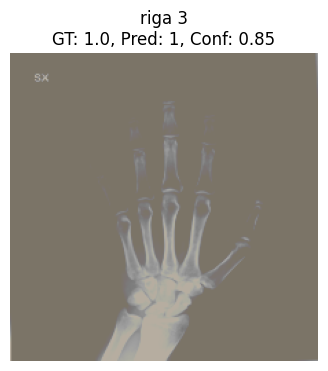

Report: Frattura lievemente scomposta e ingranata della base del V metacarpo.
Rapporti articolari congrui.
GT: 1.0, Pred: 1, Confidence: 0.8544
----------------------------------------


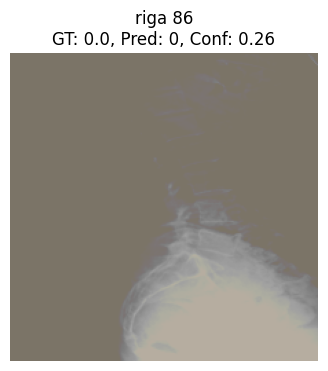

Report: Rx rachide Sacrococcigeo
Rx Rachide Lombosacrale
Con i limiti intrinseci della metodica, non evidenti rime di frattura.
GT: 0.0, Pred: 0, Confidence: 0.2639
----------------------------------------


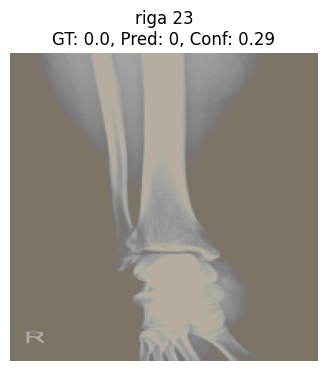

Report: RX caviglia destra
Non evidenti rime di frattura in atto.
Conservati i rapporti articolari.
GT: 0.0, Pred: 0, Confidence: 0.2904
----------------------------------------


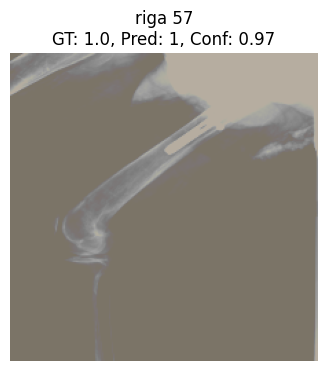

Report: Ginocchio destro
Frattura diametaepifisaria distale del femore, articolare, con modesto ingranamento e angolazione dei frammenti.
Esiti di osteosintesi femorale prossimale.
Torace. Indagine eseguita in AP, a Paziente supina.
Non si documentano franche immagini riferibili ad addensamenti parenchimali di significato flogistico in atto.
Diffusa accentuazione del disegno polmonare.
Nei limiti il circolo polmonare.
L'immagine cardiaca appare ingrandita con salienza dell'arco inferiore di sinistra.
Calcificazioni parietali aortiche.
GT: 1.0, Pred: 1, Confidence: 0.9699
----------------------------------------


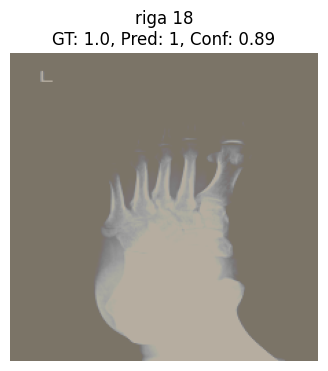

Report: RX piede sinistro
Frattura della base del V metatarsale.
GT: 1.0, Pred: 1, Confidence: 0.8885
----------------------------------------


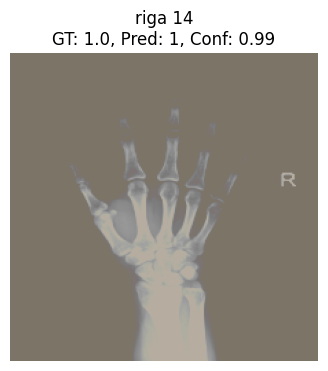

Report: Mano destra
Frattura sostanzialmente composta metaepifisaria distale della falange intermedia del IV raggio. Non lussazioni.
GT: 1.0, Pred: 1, Confidence: 0.9895
----------------------------------------


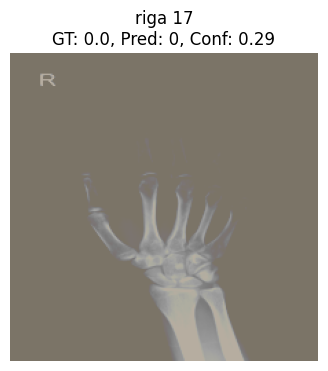

Report: RX IV raggio mano destra
Non evidenti rime di frattura in atto.
Conservati i rapporti articolari; atteggiamento in flessione dell'articolazione interfalangea prossimale.
GT: 0.0, Pred: 0, Confidence: 0.2916
----------------------------------------


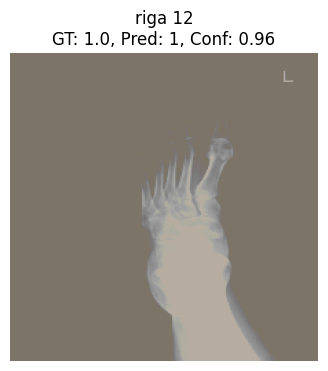

Report: Piede sinistro
Frattura articolare metaepifisaria distale della falange prossimale del V raggio, lievemente ingranata.
Frattura composta alla falange ungueale del V raggio.
Non lussazioni.
GT: 1.0, Pred: 1, Confidence: 0.9559
----------------------------------------


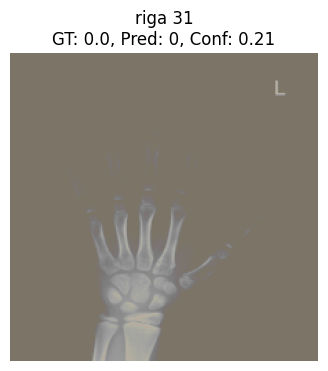

Report: RX II dito mano sinistra
Non evidenti rime di frattura in atto.
Conservati i rapporti articolari.
GT: 0.0, Pred: 0, Confidence: 0.2107
----------------------------------------


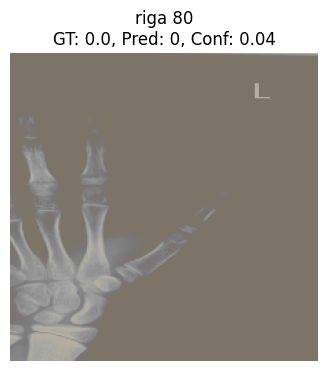

Report: Rx Mano sx
Non immagini riferibili a rime di frattura.
Regolari i rapporti articolari.
GT: 0.0, Pred: 0, Confidence: 0.0386
----------------------------------------


In [14]:
import matplotlib.pyplot as plt

for i in range(len(y_true)):
    # Get the sample from the test dataset
    sample = test_dataset[i]
    # Get image tensor and convert to numpy for plotting
    img = sample["pixel_values"][0].cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # (C, H, W) -> (H, W, C)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize if needed
    img = np.clip(img, 0, 1)

    # Get report text if available
    report = sample.get("text", "No report available")
    case_id = sample.get("case_id", f"Sample {i+1}")
    gt = y_true[i]
    pred = y_pred[i]
    conf = y_pred_probs[i]

    # Plot image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{case_id}\nGT: {gt}, Pred: {pred}, Conf: {conf:.2f}")
    plt.show()

    # Print report and output
    print(f"Report: {report}")
    print(f"GT: {gt}, Pred: {pred}, Confidence: {conf:.4f}\n{'-'*40}")